Column definitions (from project challenge description)

    DATOP - Date of flight
    FLTID - Flight number
    DEPSTN - Departure point
    ARRSTN - Arrival point
    STD - Scheduled Time departure
    STA - Scheduled Time arrival
    STATUS - Flight status
    ETD - Expected Time departure
    ETA - Expected Time arrival
    ATD - Actual Time of Departure
    ATA - Actual Time of arrival
    DELAY1 - Delay code 1
    DUR1 - delay time 1
    DELAY2 - Delay code 2
    DUR2 - delay time 2
    DELAY3 - Delay code 3
    DUR3 - delay time 3
    DELAY4 - Delay code 4
    DUR4 - delay time 4
    AC - Aircraft Code


In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import pickle

#import supporting functions used for cleaning
from supporting_functions import prediction_plot, make_combined_prediction

In [2]:
# load data (cleaned with preprocess_data.ipynb)
with open('data/clean_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

X_train            = loaded_data[0]
X_test             = loaded_data[1]
y_train            = loaded_data[2]
y_test             = loaded_data[3]
discarded_features = loaded_data[4]
scaler             = loaded_data[5]

In [3]:
# load classification model
with open('models/xgboost_classifier.pkl', 'rb') as f:
    Grid_search = pickle.load(f)
classification_model = Grid_search.best_estimator_

In [4]:
# load regression model
with open('models/xgboost_regression.pkl', 'rb') as f:
    Grid_search = pickle.load(f)
regression_model = Grid_search.best_estimator_

## Calculate and evaluate very simplistic (baseline) model that just predicts a constant (the average) for all delays

Train Mean Squared Error: 13645.465615534431
test Mean Squared Error: 14041.052359999541


Text(0.5, 1.0, 'Test Set (MSE: 14041.05)')

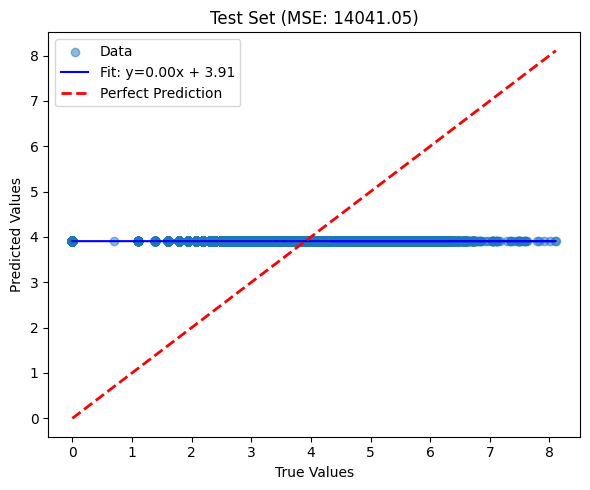

In [5]:
y_pred_train = np.zeros(np.shape(y_train)) + np.log1p(np.mean(np.expm1(y_train)))
y_pred       = np.zeros(np.shape(y_test))  + np.log1p(np.mean(np.expm1(y_train)))

train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))
test_mse  = mean_squared_error(np.expm1(y_test),  np.expm1(y_pred))

print("Train Mean Squared Error:", train_mse)
print("test Mean Squared Error:",  test_mse)

prediction_plot(y_test,y_pred)
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
plt.title(f'Test Set (MSE: {test_mse:.2f})')

## Make prediction using the combined models

In [6]:
y_pred_train = make_combined_prediction(X_train,classification_model,regression_model)
y_pred       = make_combined_prediction(X_test, classification_model,regression_model)

Train Mean Squared Error: 11589.044871222743
test Mean Squared Error: 12960.190998297496


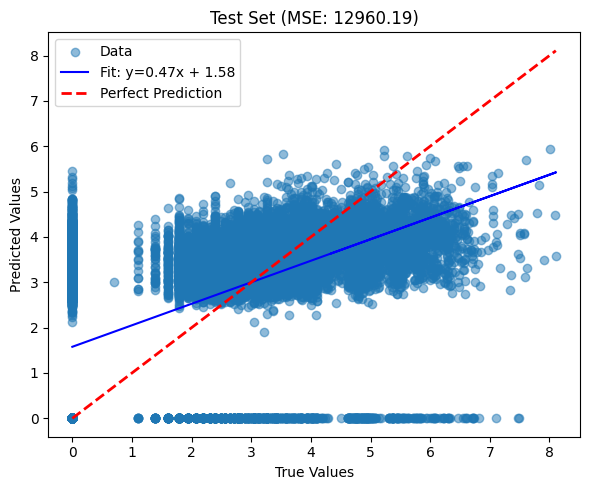

In [7]:
train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))
test_mse  = mean_squared_error(np.expm1(y_test),  np.expm1(y_pred))

print("Train Mean Squared Error:", train_mse)
print("test Mean Squared Error:",  test_mse)

prediction_plot(y_test,y_pred)
plt.title(f'Test Set (MSE: {test_mse:.2f})')
plt.savefig('./plots/Combined_prediction_plot.png', bbox_inches='tight',transparent=True)

In [8]:
y_pred_train = make_combined_prediction(X_train,classification_model,regression_model)


In [9]:
from supporting_functions import compute_feature_importance

npermutes = 25
metric    = mean_squared_error

#calculate feature importance
feature_importance, feature_labels = compute_feature_importance(X_test, y_test, classification_model, regression_model, metric, npermutes)

base metric = 12960.190998297496
permutaiton 1 / 25
permutaiton 2 / 25
permutaiton 3 / 25
permutaiton 4 / 25
permutaiton 5 / 25
permutaiton 6 / 25
permutaiton 7 / 25
permutaiton 8 / 25
permutaiton 9 / 25
permutaiton 10 / 25
permutaiton 11 / 25
permutaiton 12 / 25
permutaiton 13 / 25
permutaiton 14 / 25
permutaiton 15 / 25
permutaiton 16 / 25
permutaiton 17 / 25
permutaiton 18 / 25
permutaiton 19 / 25
permutaiton 20 / 25
permutaiton 21 / 25
permutaiton 22 / 25
permutaiton 23 / 25
permutaiton 24 / 25
permutaiton 25 / 25


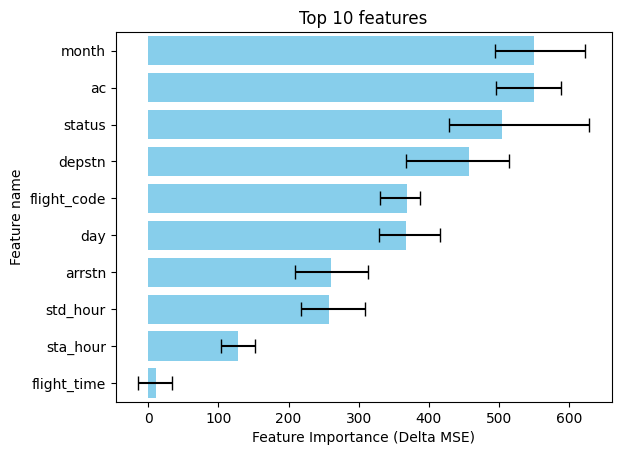

In [10]:
from supporting_functions import feature_importance_plot

N = 10 #how many features do we want to show in the plot
feature_importance_plot(feature_importance,feature_labels,N)
plt.savefig('./plots/Feature_importance_plot.png', bbox_inches='tight',transparent=True)